In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [18]:
df = pd.read_csv("tanzania_mobile_money_data.csv")
df.head()


,date,day_of_week,month,is_weekend,season,prev_day_revenue,revenue_tzs
0,2024-01-01,1,1,No,High,0,45200000
1,2024-01-02,2,1,No,High,45200000,46100000
2,2024-01-03,3,1,No,High,46100000,47300000
3,2024-01-04,4,1,No,High,47300000,49200000
4,2024-01-05,5,1,No,High,49200000,55300000


In [19]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              547 non-null    object
 1   day_of_week       547 non-null    int64 
 2   month             547 non-null    int64 
 3   is_weekend        547 non-null    object
 4   season            547 non-null    object
 5   prev_day_revenue  547 non-null    int64 
 6   revenue_tzs       547 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 30.0+ KB


In [20]:
df.isnull().sum()


date                0
day_of_week         0
month               0
is_weekend          0
season              0
prev_day_revenue    0
revenue_tzs         0
dtype: int64

In [21]:
df.describe()


,day_of_week,month,prev_day_revenue,revenue_tzs
count,547.000000,547.000000,5.470000e+02,5.470000e+02
mean,3.994516,5.519196,5.869945e+07,5.881810e+07
std,2.004109,3.310143,9.808906e+06,9.484739e+06
min,1.000000,1.000000,0.000000e+00,4.090000e+07
25%,2.000000,3.000000,5.125000e+07,5.155000e+07
50%,4.000000,5.000000,5.770000e+07,5.770000e+07
75%,6.000000,8.000000,6.510000e+07,6.510000e+07
max,7.000000,12.000000,8.720000e+07,8.720000e+07


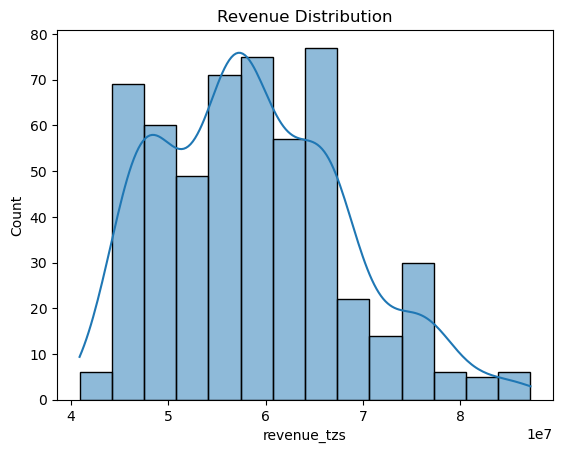

In [23]:
plt.figure()
sns.histplot(df["revenue_tzs"], kde=True)
plt.title("Revenue Distribution")
plt.show()


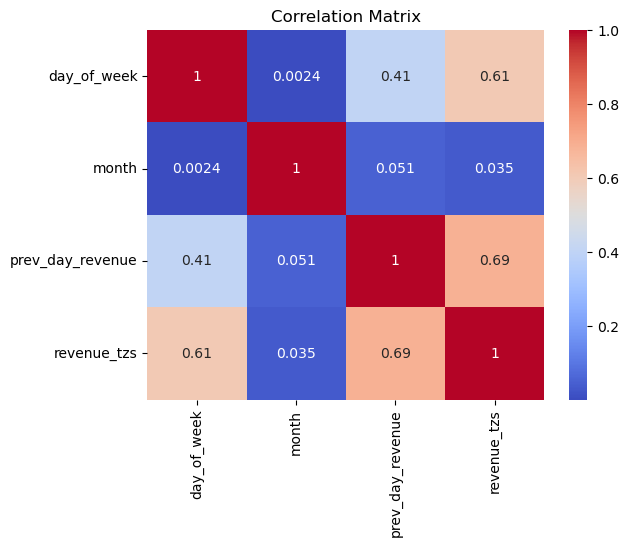

In [24]:
plt.figure()
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [25]:
le_weekend = LabelEncoder()
le_season = LabelEncoder()

df["is_weekend"] = le_weekend.fit_transform(df["is_weekend"])
df["season"] = le_season.fit_transform(df["season"])


In [26]:
X = df[["day_of_week", "month", "is_weekend", "season", "prev_day_revenue"]]
y = df["revenue_tzs"]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression Results")
print("MAE:", lr_mae)
print("MSE:", lr_mse)
print("R2:", lr_r2)


Linear Regression Results
MAE: 4472595.229349911
MSE: 34521303307355.25
R2: 0.47593789185491586


In [30]:
lr_cv = cross_val_score(lr, X, y, cv=5, scoring="r2")
print("Linear Regression CV R2 Mean:", lr_cv.mean())


Linear Regression CV R2 Mean: 0.15079908518570492


In [31]:
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

dt_mae = mean_absolute_error(y_test, dt_pred)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)

print("Decision Tree Results")
print("MAE:", dt_mae)
print("MSE:", dt_mse)
print("R2:", dt_r2)


Decision Tree Results
MAE: 1362352.6093928202
MSE: 4976915553096.422
R2: 0.9244462807909094


In [32]:
dt_cv = cross_val_score(dt, X, y, cv=5, scoring="r2")
print("Decision Tree CV R2 Mean:", dt_cv.mean())


Decision Tree CV R2 Mean: 0.7941085628572315


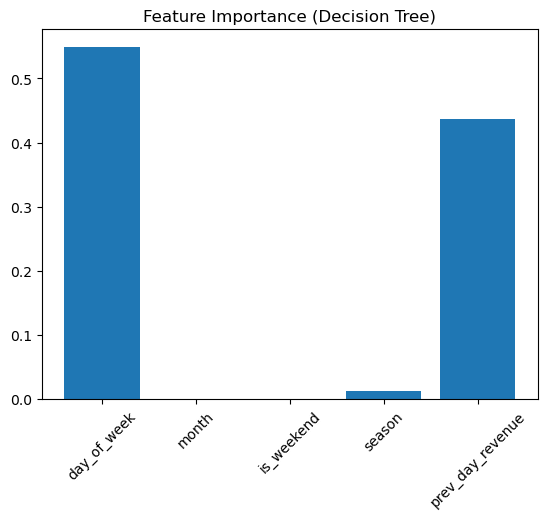

In [33]:
importances = dt.feature_importances_
features = ["day_of_week", "month", "is_weekend", "season", "prev_day_revenue"]

plt.figure()
plt.bar(features, importances)
plt.title("Feature Importance (Decision Tree)")
plt.xticks(rotation=45)
plt.show()


In [34]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree"],
    "R2": [lr_r2, dt_r2],
    "CV_R2_Mean": [lr_cv.mean(), dt_cv.mean()]
})

results


,Model,R2,CV_R2_Mean
0,Linear Regression,0.475938,0.150799
1,Decision Tree,0.924446,0.794109


In [35]:
if dt_r2 > lr_r2:
    best_model = dt
    print("Best Model: Decision Tree")
else:
    best_model = lr
    print("Best Model: Linear Regression")


Best Model: Decision Tree


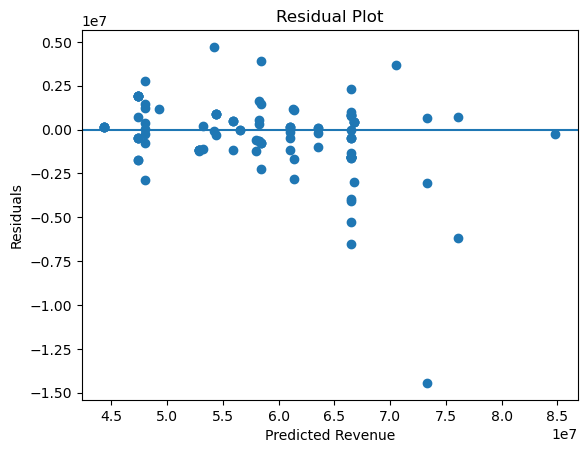

In [41]:
residuals = y_test - best_model.predict(X_test)

plt.figure()
plt.scatter(best_model.predict(X_test), residuals)
plt.axhline(y=0)
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


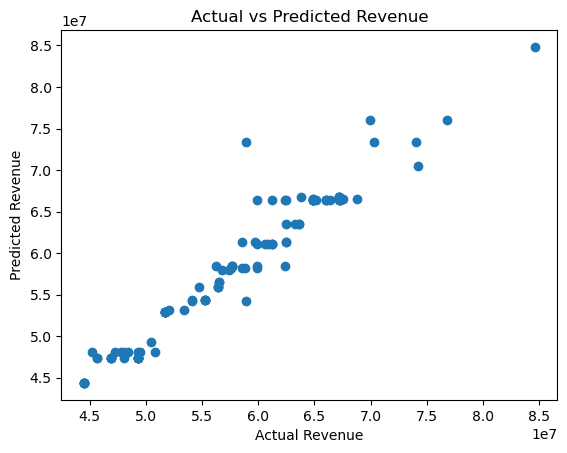

In [36]:
plt.figure()
plt.scatter(y_test, best_model.predict(X_test))
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.show()


In [39]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(best_model, "model.pkl")



['model.pkl']